## Exposición

In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterstats
from rasterio.features import rasterize


import rioxarray


USE_CRS = "EPSG:5347" # posgar para esperanza
TRANSFORM = ""
SHAPE = ""
NODATA = 0
DTYPE = int
ALL_TOUCHED = False

In [31]:
datos_censales = gpd.read_parquet(
    "/home/nissim/Documents/dev/fulbright/ciut-redatam/datos_censales_2022_geo.parquet"
)

datos_censales = datos_censales.to_crs(USE_CRS)

In [12]:
from io import BytesIO, StringIO
from owslib.wfs import WebFeatureService

def wfs_to_gdf(
    wfs_url: str, layer_name: str, srs: str = "EPSG:4326"
) -> gpd.GeoDataFrame:
    """
    Descarga una capa WFS y la devuelve como GeoDataFrame.

    Args:
        wfs_url (str): URL del servicio WFS.
        layer_name (str): Nombre de la capa (typename).
        srs (str): Código EPSG del sistema de referencia de coordenadas.

    Returns:
        gpd.GeoDataFrame: Capa descargada como GeoDataFrame.
    """
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")
    response = wfs.getfeature(typename=layer_name, srsname=srs)
    gdf = gpd.read_file(BytesIO(response.read()))
    return gdf

In [13]:
# Clean base URL (remove all WFS parameters)
base_url = "https://wms.ign.gob.ar/geoserver/ign/ows"

# Use the function with proper parameters
munis = wfs_to_gdf(
    wfs_url=base_url,
    layer_name="ign:municipio", 
    srs="EPSG:4326"
)

In [32]:
esperanza = munis[munis['nam'] == 'Esperanza']
esperanza = esperanza.to_crs(USE_CRS)

<Axes: >

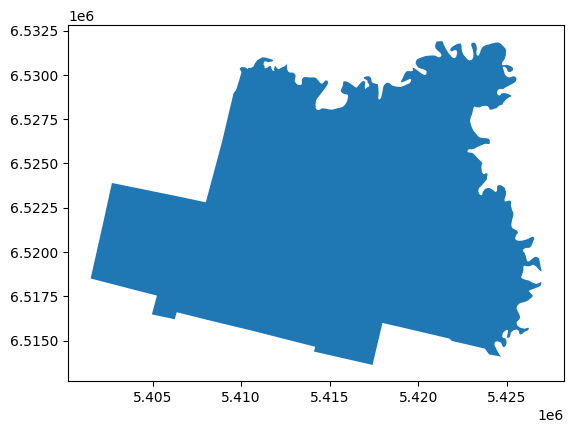

In [34]:
esperanza.plot()

In [35]:
datos_censales_esperanza = datos_censales.clip(esperanza)

<Axes: >

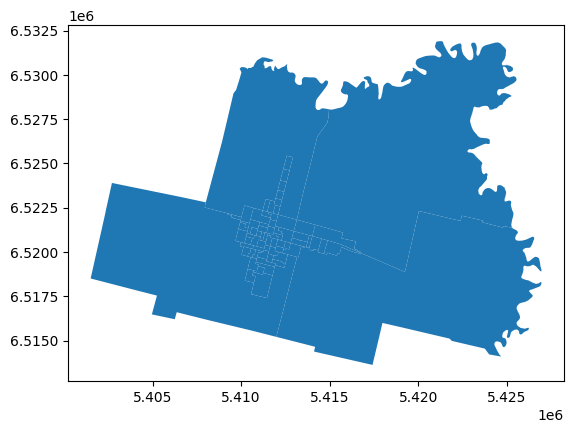

In [36]:
datos_censales_esperanza.plot()

In [37]:
# Load GHSL data with dask chunking for memory efficiency
ghsl = rioxarray.open_rasterio(
    "/home/nissim/Documents/dev/fulbright/ciut-riesgo/notebooks/data/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.tif",
    chunks={"x": 1024, "y": 1024},  # Adjust chunk size based on your memory constraints
)

# Reproject to your target CRS with streaming
ghsl = ghsl.rio.reproject(dst_crs=USE_CRS)

# Clip GHSL data to ONLY the Partido de La Plata boundaries
# This will remove any GHSL data outside the partido
ghsl_clipped = ghsl.rio.clip(
    [esperanza.geometry.iloc[0]],  # Use the actual La Plata partido geometry
    from_disk=True,  # Process from disk to avoid loading entire dataset into memory
)

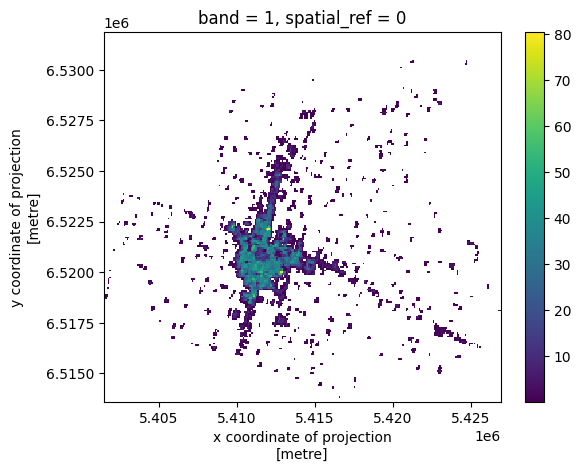

In [38]:
# Mask values <= 0, replacing them with NaN
ghsl_masked = ghsl_clipped.where(ghsl_clipped > 0)
ghsl_masked.plot()

In [39]:
# Step 1: Calculate the total GHSL population per barrio popular using zonal statistics

# Convert to the format expected by rasterstats
geometries = [geom for geom in datos_censales_esperanza.geometry]

# Use rasterstats for vectorized zonal statistics
stats = rasterstats.zonal_stats(
    geometries,
    ghsl_clipped.values[0],  # rasterstats expects 2D array
    affine=ghsl_clipped.rio.transform(),
    stats=["sum"],
    nodata=ghsl_clipped.rio.nodata,
)

# Extract the sum values
ghsl_totals = [stat["sum"] if stat["sum"] is not None else 0 for stat in stats]

In [42]:
# Add the GHSL population estimates as a new column
datos_censales_esperanza["ghsl_pop_est"] = ghsl_totals


# Get the reference raster properties from GHSL data
reference_raster = ghsl_clipped
reference_transform = reference_raster.rio.transform()
reference_crs = reference_raster.rio.crs
reference_shape = reference_raster.shape[1:]  # Get 2D shape (height, width)


# Prepare geometries and values for rasterization
geometries_ghsl = [
    (geom, value)
    for geom, value in zip(
        datos_censales_esperanza.geometry, datos_censales_esperanza["ghsl_pop_est"]
    )
]
geometries_pop = [
    (geom, value)
    for geom, value in zip(
        datos_censales_esperanza.geometry, datos_censales_esperanza["POB_TOT_P"]
    )
]

In [53]:
# Create GHSL population raster
ghsl_pop_raster = rasterize(
    geometries_ghsl,
    out_shape=reference_shape,
    transform=reference_transform,
    fill=0,
    dtype=np.float32,
    all_touched=True,
)

# Create pop aproximadas raster
pop_raster = rasterize(
    geometries_pop,
    out_shape=reference_shape,
    transform=reference_transform,
    fill=0,
    dtype=np.float32,
    all_touched=True,
)


# Step 1: Divide original GHSL by the barrio-level GHSL to get fractional population
# Use masking to avoid division on invalid cells
mask = (ghsl_clipped.values[0] != -200) & (ghsl_pop_raster > 0.1)
ghsl_fractional = np.full_like(ghsl_clipped.values[0], -200, dtype=np.float64)
ghsl_fractional[mask] = ghsl_clipped.values[0][mask] / ghsl_pop_raster[mask]

# Step 2: Multiply fractional population by pop aproximadas to get downscaled data
mask2 = (ghsl_fractional != -200) & (pop_raster > 0)
pop_downscaled = np.full_like(ghsl_clipped.values[0], -200, dtype=np.float64)
pop_downscaled[mask2] = ghsl_fractional[mask2] * pop_raster[mask2]

# Verify the results - exclude -200 from range calculations
ghsl_valid = ghsl_clipped.values[0] != -200
fractional_valid = ghsl_fractional != -200
downscaled_valid = pop_downscaled != -200

In [52]:
# Calculate total from downscaled data (excluding nodata values)
downscaled_total = pop_downscaled[pop_downscaled != -200].sum()

# Calculate total from census data (assuming you have this in your geodataframe)
# This depends on which column contains the population in your census data
census_total = datos_censales_esperanza['POB_TOT_P'].sum()  # Replace with actual column name

print(f"Downscaled population total: {downscaled_total:,.0f}")
print(f"Census population total: {census_total:,.0f}")
print(f"Difference: {downscaled_total - census_total:,.0f}")
print(f"Ratio (downscaled/census): {downscaled_total/census_total:.2f}")

Downscaled population total: 47,204
Census population total: 50,324
Difference: -3,120
Ratio (downscaled/census): 0.94


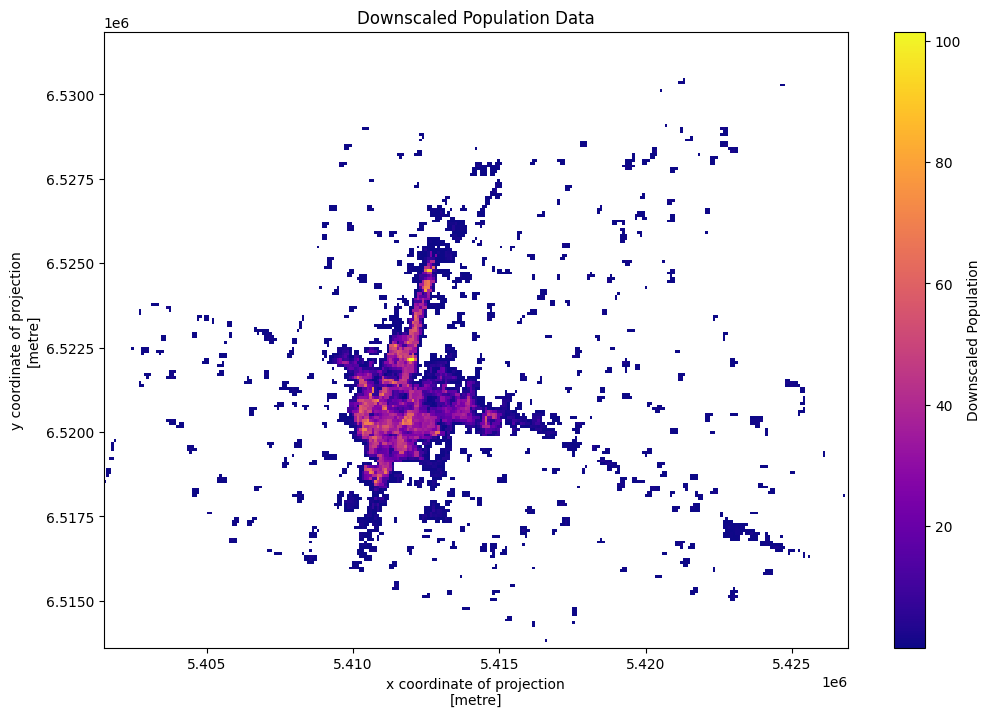

In [54]:
import xarray as xr

# Convert the downscaled numpy array back to xarray DataArray
pop_downscaled_da = xr.DataArray(
    pop_downscaled,
    coords={'y': ghsl_clipped.y, 'x': ghsl_clipped.x},
    dims=['y', 'x'],
    attrs=ghsl_clipped.attrs.copy()
)

# Mask out nodata values (-200) and values <= 0
pop_downscaled_masked = pop_downscaled_da.where(
    (pop_downscaled_da > 0) & (pop_downscaled_da != -200)
)

# Plot with better visualization
pop_downscaled_masked.plot(
    figsize=(12, 8),
    cmap='plasma',
    cbar_kwargs={'label': 'Downscaled Population'}
)
plt.title('Downscaled Population Data')
plt.show()

In [1]:
import matplotlib.pyplot as plt

from shapely.geometry import box
import geopandas as gpd
import os


from matplotlib_map_utils import north_arrow, scale_bar


import contextily as cx


import pandas as pd
import contextily as ctx


import boto3
import duckdb
import s2sphere
from botocore.config import Config


from io import BytesIO
from owslib.wfs import WebFeatureService


USE_CRS = "EPSG:5349"  # POSGAR 2007 / Argentina 4
WEB_MERCATOR_CRS = "EPSG:3857"  # visualización
WGS84_CRS = "EPSG:4326"  # para llamadas API

BASE_RUTA = "/home/nissim/Documents/dev/fulbright/ciut-riesgo"
DATA_RUTA = f"{BASE_RUTA}/notebooks/data"
PARTIDOS_RUTA = f"{DATA_RUTA}/pba_partidos.geojson"
EDIFICACIONES_RUTA = f"{BASE_RUTA}/notebooks/edificaciones_filtered.parquet"

PARTIDOS_WFS_URL = "https://geo.arba.gov.ar/geoserver/idera/wfs"

ModuleNotFoundError: No module named 'matplotlib_map_utils'

In [2]:
if os.path.exists(PARTIDOS_RUTA):
    print("Cargando datos de partidos existentes...")
    partidos = gpd.read_file(PARTIDOS_RUTA)
else:
    print("Descargando datos de partidos desde servicio WFS...")

    # Conectar al servicio WFS
    wfs = WebFeatureService(url=PARTIDOS_WFS_URL, version="2.0.0")

    # Descargar la capa de departamentos
    response = wfs.getfeature(typename="idera:Departamento", srsname="EPSG:5347")

    # Convertir a GeoDataFrame
    partidos = gpd.read_file(BytesIO(response.read()))

    # Guardar para uso futuro
    partidos.to_file(PARTIDOS_RUTA, driver="GeoJSON")
    print(f"Descargados {len(partidos)} partidos")

partidos = partidos.to_crs(USE_CRS)
aoi = partidos[partidos["fna"] == "Partido de La Plata"]

# Obtener la geometría principal
main_geom = aoi.geometry.iloc[0]

# Si es un MultiPolygon, mantener solo el polígono más grande (el partido principal)
# Esto elimina la pequeña isla que aparece en los datos
if main_geom.geom_type == "MultiPolygon":
    # Obtener todos los polígonos y mantener el que tenga mayor área
    largest_polygon = max(main_geom.geoms, key=lambda p: p.area)
    aoi = aoi.copy()  # Crear una copia para evitar SettingWithCopyWarning
    aoi.loc[aoi.index[0], "geometry"] = largest_polygon

aoi_bbox = aoi.geometry.iloc[0]

if os.path.exists(EDIFICACIONES_RUTA):
    print("Cargando datos de edificaciones existentes...")
    edificaciones = gpd.read_parquet(EDIFICACIONES_RUTA)
else:
    print("Obteniendo datos de edificaciones del dataset VIDA...")

    # Paso 1: Obtener el punto central de La Plata en coordenadas WGS84
    aoi_buffered = aoi.buffer(500)  # Agregar buffer de 500m para obtener datos
    center = aoi_buffered.to_crs(WEB_MERCATOR_CRS).union_all().centroid
    center_wgs84 = (
        gpd.GeoDataFrame(geometry=[center], crs=WEB_MERCATOR_CRS)
        .to_crs(WGS84_CRS)
        .geometry.iloc[0]
    )
    print(f"Coordenadas del centro: {center_wgs84.y:.4f}, {center_wgs84.x:.4f}")

    # Paso 2: Encontrar la celda S2 apropiada para particionamiento espacial
    cell = s2sphere.CellId.from_lat_lng(
        s2sphere.LatLng.from_degrees(center_wgs84.y, center_wgs84.x)
    ).parent(10)
    print(f"ID de celda S2: {cell.id()}")

    # Paso 3: Obtener bounding box en WGS84 para filtrado espacial
    bounds = aoi_buffered.to_crs(WGS84_CRS).total_bounds
    print(f"Caja delimitadora: {bounds}")

    # Paso 4: Conectar a S3 y encontrar particiones disponibles
    s3 = boto3.client(
        "s3",
        endpoint_url="https://data.source.coop",
        aws_access_key_id="",
        aws_secret_access_key="",
        config=Config(s3={"addressing_style": "path"}),
    )

    # Obtener lista de particiones S2 disponibles
    partitions = {
        obj["Key"].split("/")[-1].replace(".parquet", "")
        for obj in s3.list_objects_v2(
            Bucket="vida",
            Prefix="google-microsoft-osm-open-buildings/geoparquet/by_country_s2/country_iso=ARG/",
        ).get("Contents", [])
    }
    print(f"Encontradas {len(partitions)} particiones disponibles")

    # Paso 5: Encontrar la partición padre apropiada
    parent_id = next(
        str(cell.parent(level).id())
        for level in range(10, 0, -1)
        if str(cell.parent(level).id()) in partitions
    )
    print(f"Usando partición: {parent_id}")

    # Paso 6: Configurar DuckDB para consultas espaciales
    con = duckdb.connect()
    print("Configurando DuckDB con extensiones espaciales...")
    for cmd in [
        "INSTALL spatial",
        "LOAD spatial",
        "INSTALL httpfs",
        "LOAD httpfs",
        "SET s3_region='us-east-1'",
        "SET s3_endpoint='data.source.coop'",
        "SET s3_use_ssl=true",
        "SET s3_url_style='path'",
    ]:
        con.execute(cmd)

    # Paso 7: Consultar y filtrar edificaciones dentro de nuestra área de interés
    print("Consultando edificaciones dentro del área de La Plata...")
    query = f"""
    COPY (SELECT * FROM 's3://vida/google-microsoft-osm-open-buildings/geoparquet/by_country_s2/country_iso=ARG/{parent_id}.parquet'
          WHERE bbox.xmax >= {bounds[0]} AND bbox.xmin <= {bounds[2]} AND
                bbox.ymax >= {bounds[1]} AND bbox.ymin <= {bounds[3]}
    ) TO '{EDIFICACIONES_RUTA}' (FORMAT PARQUET);
    """

    con.execute(query)

    # Paso 8: Cargar los datos filtrados y convertir a GeoDataFrame
    df = pd.read_parquet(EDIFICACIONES_RUTA)
    df["geometry"] = gpd.GeoSeries.from_wkb(df["geometry"])
    edificaciones = gpd.GeoDataFrame(df, geometry="geometry", crs=WGS84_CRS)

    print(f"Obtenidas {len(edificaciones)} edificaciones")
    con.close()


# Filtrar edificaciones para incluir solo las que están dentro de los límites de La Plata
edificaciones_proj = edificaciones.to_crs(USE_CRS)
edificaciones_proj = edificaciones_proj[
    edificaciones_proj.geometry.intersects(aoi_bbox)
]

NameError: name 'PARTIDOS_RUTA' is not defined

In [ ]:
# Obtener límites de La Plata y convertir a Web Mercator para visualización
aoi_bounds = aoi_bbox.bounds
temp_bounds = gpd.GeoDataFrame(
    geometry=[box(aoi_bounds[0], aoi_bounds[1], aoi_bounds[2], aoi_bounds[3])],
    crs=USE_CRS,
)
bounds_3857 = temp_bounds.to_crs(WEB_MERCATOR_CRS).total_bounds

fig, ax = plt.subplots(figsize=(12, 10))
ax.set_xlim(bounds_3857[0] - 500, bounds_3857[2] + 500)
ax.set_ylim(bounds_3857[1] - 500, bounds_3857[3] + 500)

cx.add_basemap(
    ax,
    crs=WEB_MERCATOR_CRS,
    source=ctx.providers.CartoDB.PositronNoLabels,
    attribution="Datos: VIDA (2023), IGN (2025) | Mapa base: Carto (2025)",
)

scale_bar(
    ax=ax,
    location="upper left",
    style="ticks",
    bar={
        "projection": "EPSG:3857",
        "tickcolors": "black",
        "basecolors": "black",
        "minor_type": "none",
        "length": 0.20,
    },
    labels={"style": "first_last"},
)

# Add north arrow
north_arrow(
    ax,
    location="upper right",
    scale=0.3,
    rotation={"degrees": 0},
    base={"facecolor": "none", "edgecolor": "black", "linewidth": 1},
    fancy=True,
    shadow=True,
    label=False,
)

aoi_3857 = aoi.to_crs(WEB_MERCATOR_CRS)
aoi_3857.plot(
    ax=ax,
    facecolor="none",
    edgecolor="black",
    linewidth=0.5,
    linestyle="--",
    legend=False,
    zorder=5,
)

edificaciones_3857 = edificaciones_proj.to_crs(WEB_MERCATOR_CRS)
edificaciones_3857.plot(ax=ax, facecolor="grey", edgecolor="none", alpha=0.7)

ax.set_title("Huellas de edificios", fontsize=16, fontweight="bold", pad=20)
ax.set_axis_off()

plt.tight_layout()
plt.show()